In [1]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
import tensorflow as tf
from sklearn.model_selection import train_test_split
import plotly
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [2]:
# endpoint = 'https://min-api.cryptocompare.com/data/histoday'
# res = requests.get(endpoint + '?fsym=BTC&tsym=USD&limit=1500')
# hist = pd.DataFrame(json.loads(res.content)['Data'])
# hist = hist.set_index('time')
# hist.index = pd.to_datetime(hist.index, unit='s')
# # colonne cible
# target_col = 'close'
# # maj API, suppression des 2 colonnes string
# hist = hist.drop(['conversionType','conversionSymbol'], axis=1)

# Importation des données du Bitcoin
btc_hist_data = pd.read_csv("BTC-USD_complet.csv", index_col="Date")

btc_hist_data.head()

# Séparation du target avec les autres caractéristiques
target_btc = btc_hist_data['Close']

btc_hist = btc_hist_data.drop(['Close'], axis=1)

target_column = "Close"

btc_hist.head(5)





,Open,High,Low,Adj Close,Volume
Date,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,26580100


In [3]:
btc_hist.describe

<bound method NDFrame.describe of                     Open          High           Low     Adj Close  \
Date                                                                 
2014-09-17    465.864014    468.174011    452.421997    457.334015   
2014-09-18    456.859985    456.859985    413.104004    424.440002   
2014-09-19    424.102997    427.834991    384.532013    394.795990   
2014-09-20    394.673004    423.295990    389.882996    408.903992   
2014-09-21    408.084991    412.425995    393.181000    398.821014   
...                  ...           ...           ...           ...   
2024-01-15  41715.066406  43319.722656  41705.417969  42511.968750   
2024-01-16  42499.335938  43566.273438  42085.996094  43154.945313   
2024-01-17  43132.101563  43189.890625  42189.308594  42742.652344   
2024-01-18  42742.312500  42876.347656  40631.171875  41262.058594   
2024-01-19  41278.460938  41484.757813  40756.769531  40904.839844   

                 Volume  
Date                     
201

In [4]:
print(btc_hist.mean())
print(btc_hist.std())

Open         1.473528e+04
High         1.507954e+04
Low          1.436420e+04
Adj Close    1.474584e+04
Volume       1.662758e+10
dtype: float64
Open         1.628894e+04
High         1.667930e+04
Low          1.585105e+04
Adj Close    1.629038e+04
Volume       1.907830e+10
dtype: float64


In [42]:
def t_t_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data
train, test = t_t_split(btc_hist_data, test_size=0.2)

# Forcer le maintien de la division du datastet à chaquue exécution
# seeds = 123
# test_size=  0.2
# # train et test split
# btc_train, btc_test, target_train, target_test = train_test_split(
#         btc_hist, target_btc,
#         test_size=0.2,
#         random_state=seeds
#     )



# # Train et test du datframe initial
# def t_t_split(df, test_size, seeds):
#     btc_train, btc_test,d,f = train_test_split(df,df, test_size=test_size, random_state=seeds)
#     return btc_train, btc_test
# train, test = t_t_split(btc_hist_data, test_size,seeds)


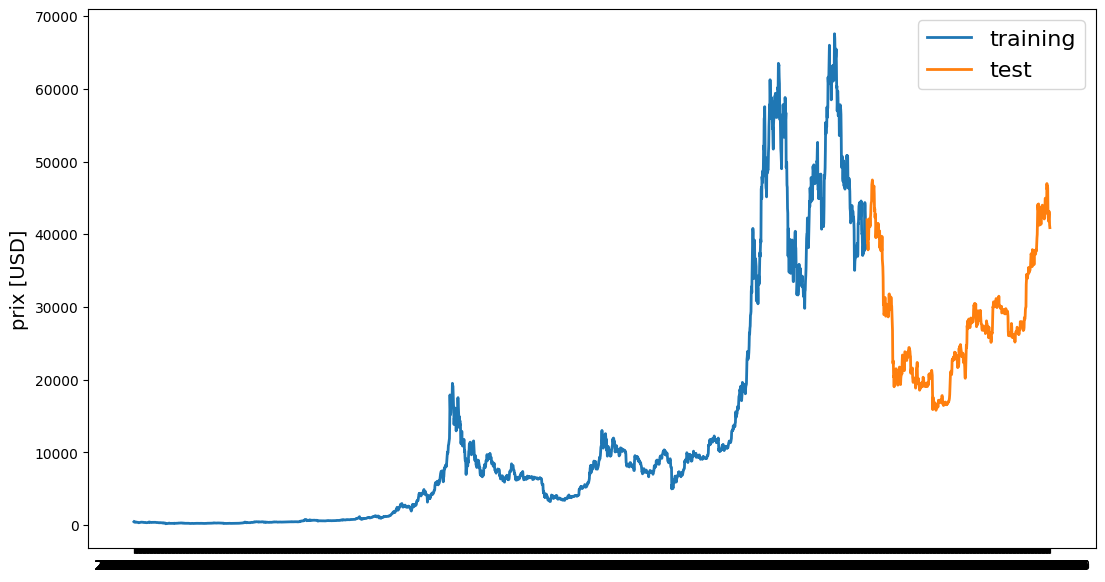

In [43]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('prix [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16)
line_plot(train[target_column], test[target_column], 'training', 'test', title='')

In [44]:
def normaliser_zero_base(dataframe):
    return dataframe / dataframe.iloc[0] - 1

# Noramliser les données en utilisant le MinMax
def normaliser_min_max(dataframe):
    return (dataframe - dataframe.min()) / (dataframe.max() - dataframe.min())

# Extraire des fenêtres de données de taille 5
def extract_window_data(dataframe, window_lenght=5, zero_base=True):
    window_data = []
    for index in range(len(dataframe) - window_lenght):
        temp_save = dataframe[index: (index + window_lenght)].copy()
        if zero_base:
            temp_save = normaliser_zero_base(temp_save)
        window_data.append(temp_save.values)
    return np.array(window_data)

# # Noramlisation
# scaler = StandardScaler()
# btc_hist_normalised = scaler.fit_transform(btc_hist)

# print(btc_hist_normalised.mean())
# print(btc_hist_normalised.std())

# btc_hist_normalised
# ff = (btc_hist - btc_hist.mean())
# tt = btc_hist.std()
# ff = ff/tt
# print(ff.head(5))
# print(ff.mean())

# # Noramlisation avec MinMaxScaler
# min_max_scaler = MinMaxScaler()
# btc_hist_min_max_norm = min_max_scaler.fit_transform(btc_hist)
# print(btc_hist_min_max_norm)

In [45]:
# La préparation des données 

# def prepare_data(btc_train, btc_test, target_train, target_test):
def prepare_data(btc_hist, target_btc, target_column, window_len=10, zero_base=True):
    train_data, test_data = btc_hist, target_btc
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_column][window_len:].values
    y_test = test_data[target_column][window_len:].values
    
    if zero_base:
        y_train = y_train / train_data[target_column][:-window_len].values - 1
        y_test = y_test / test_data[target_column][:-window_len].values - 1
    return train_data, test_data, X_train, X_test, y_train, y_test
# return btc_train, btc_test, target_train, target_test

In [62]:
#La construction du modèle en LSTM
def lstm_model_building(input_data, output_size, neurons=300, activ_func='linear', dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))
    model.compile(loss=loss, optimizer=optimizer)
    return model

# btc_train.shape[1]

In [63]:
# Les informations desquelles nous nous servirions pour l'utilisation du modèle
np.random.seed(123)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 500
epochs = 100
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [64]:
train_data, test_data, X_train, X_test, y_train, y_test = prepare_data(train, test, target_column, window_len=window_len, zero_base=True)
model = lstm_model_building(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
btc_history = model.fit(
    X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)

Epoch 1/100
86/86 [==============================] - 7s 41ms/step - loss: 0.0031
Epoch 2/100
86/86 [==============================] - 4s 41ms/step - loss: 0.0018
Epoch 3/100
86/86 [==============================] - 4s 44ms/step - loss: 0.0017
Epoch 4/100
86/86 [==============================] - 4s 46ms/step - loss: 0.0016
Epoch 5/100
86/86 [==============================] - 4s 45ms/step - loss: 0.0016
Epoch 6/100
86/86 [==============================] - 4s 45ms/step - loss: 0.0016
Epoch 7/100
86/86 [==============================] - 4s 47ms/step - loss: 0.0016
Epoch 8/100
86/86 [==============================] - 4s 47ms/step - loss: 0.0016
Epoch 9/100
86/86 [==============================] - 5s 58ms/step - loss: 0.0016
Epoch 10/100
86/86 [==============================] - 4s 51ms/step - loss: 0.0016
Epoch 11/100
86/86 [==============================] - 4s 49ms/step - loss: 0.0016
Epoch 12/100
86/86 [==============================] - 4s 50ms/step - loss: 0.0016
Epoch 13/100
86/86 [=====

In [4]:
targets = test[target_column][window_len:]
preds = model.predict(X_test).squeeze()
print("Moyenne de l'errreur absolue", mean_absolute_error(preds, y_test))


NameError: name 'test' is not defined

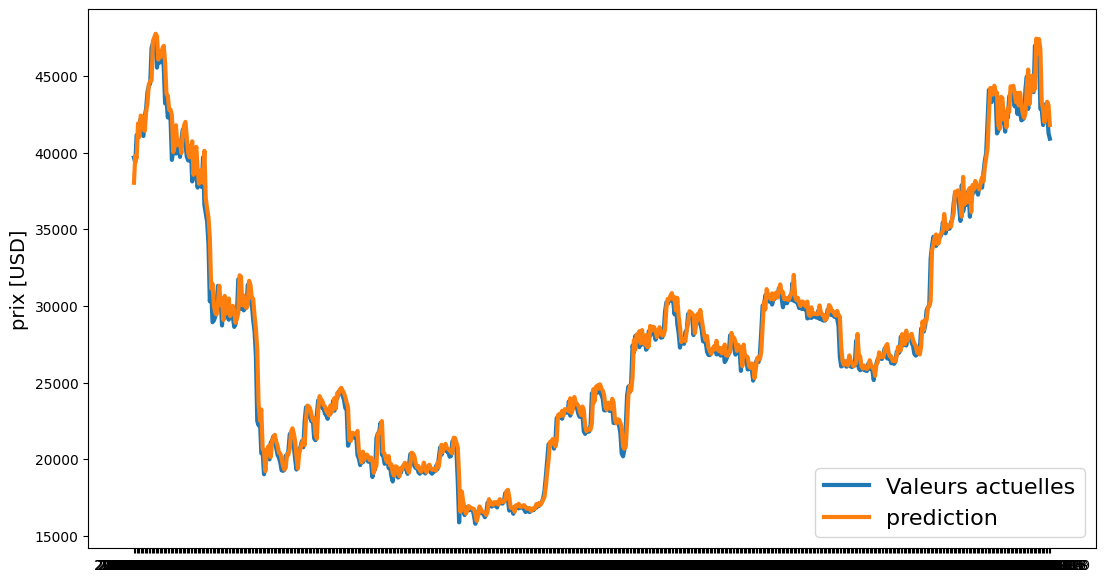

In [66]:
preds = test[target_column].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'Valeurs actuelles', 'prediction', lw=3)

In [52]:
preds.index

Index(['2022-03-14', '2022-03-15', '2022-03-16', '2022-03-17', '2022-03-18',
       '2022-03-19', '2022-03-20', '2022-03-21', '2022-03-22', '2022-03-23',
       ...
       '2024-01-10', '2024-01-11', '2024-01-12', '2024-01-13', '2024-01-14',
       '2024-01-15', '2024-01-16', '2024-01-17', '2024-01-18', '2024-01-19'],
      dtype='object', name='Date', length=677)

In [67]:
# Créez un DataFrame avec ces deux séries en tant que colonnes
data = {'Valeurs exactes': targets, 'Valeurs prédites': preds}
compare = pd.DataFrame(data)

# Affichez le DataFrame
print(compare)

            Valeurs exactes  Valeurs prédites
Date                                         
2022-03-14     39666.753906      38029.324671
2022-03-15     39338.785156      39783.294128
2022-03-16     41143.929688      39618.760356
2022-03-17     40951.378906      41899.227269
2022-03-18     41801.156250      41024.388127
...                     ...               ...
2024-01-15     42511.968750      41982.104672
2024-01-16     43154.945313      42528.143502
2024-01-17     42742.652344      43316.365492
2024-01-18     41262.058594      43092.707605
2024-01-19     40904.839844      41799.866899

[677 rows x 2 columns]


In [68]:
compare.head(10)

,Valeurs exactes,Valeurs prédites
Date,,
2022-03-14,39666.753906,38029.324671
2022-03-15,39338.785156,39783.294128
2022-03-16,41143.929688,39618.760356
2022-03-17,40951.378906,41899.227269
2022-03-18,41801.156250,41024.388127
2022-03-19,42190.652344,42407.788958
2022-03-20,41247.824219,42350.178809
2022-03-21,41077.996094,41500.538519
2022-03-22,42358.808594,41416.783859


In [69]:
compare.describe()

,Valeurs exactes,Valeurs prédites
count,677.000000,677.000000
mean,27652.763210,27876.117747
std,7988.024188,8043.994387
min,15787.284180,15970.607101
25%,21147.230469,21245.978332
50%,26851.029297,27044.465346
75%,30397.552734,30594.341393
max,47465.730469,47746.528533


In [3]:
def predict_data():
    targets = targets
    preds = preds
    
    preds = test[target_column].values[:-window_len] * (preds + 1)
    preds = pd.Series(index=targets.index, data=preds)
    return preds

def btc_data():
    return btc_hist_data
   
predict_data = predict_data()
btc_data = btc_data()

UnboundLocalError: cannot access local variable 'targets' where it is not associated with a value

## L'utilisation de la validation


In [76]:
# Enregistrer le modèle de machine learning
import joblib
crypto_predict = model
joblib.dump(crypto_predict, "crypto_course.joblib")

['crypto_course.joblib']

In [2]:
joblib.dump(predict_data, "prediction.joblib")
joblib.dump(btc_data, "btc_dataset.joblib")

NameError: name 'joblib' is not defined